# Import Core Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

# Load Dataset

In [36]:
%run load_dataset.ipynb

Loading 1001's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1002's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1003's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1004's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1005's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1006's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1007's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 1008's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 2001's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Loading 2002's data
['sit', 'sleep', 'stairs', 'stand', 'walk']
Finished loading


# Data Preprocessing

In [38]:
%run preprocess_for_SVM.ipynb
# includes wavelet denoising, normalization, PCA, LDA, SVD, etc.

In [37]:
print(X_all.shape, y_all.shape)

(19931, 3) (19931,)


# Group Data by Label and Normalize Data *

In [39]:
print(label_list)

['sit', 'sleep', 'stairs', 'stand', 'walk']


In [57]:
# denoise the signal using wavelet transform
# wavelet_output = wavelet_smooth(X_all)
# X_w = np.array(wavelet_output)

In [40]:
new_label_list = [0,1,3,2,4]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    3: 'stand',
    2: 'stairs',
    4: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [41]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all, y_all, subj_all, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

plotting  sit


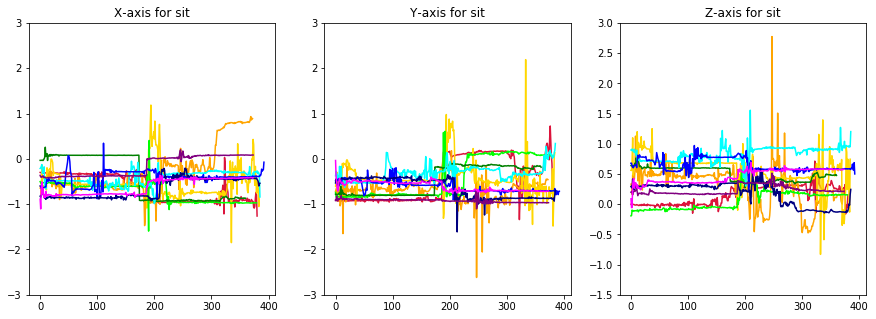

plotting  sleep


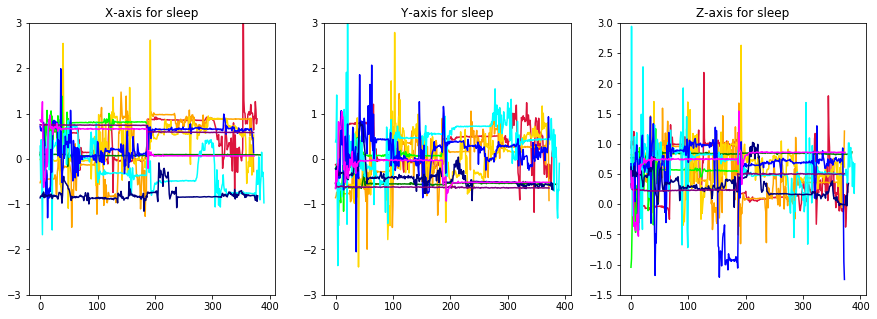

plotting  stand


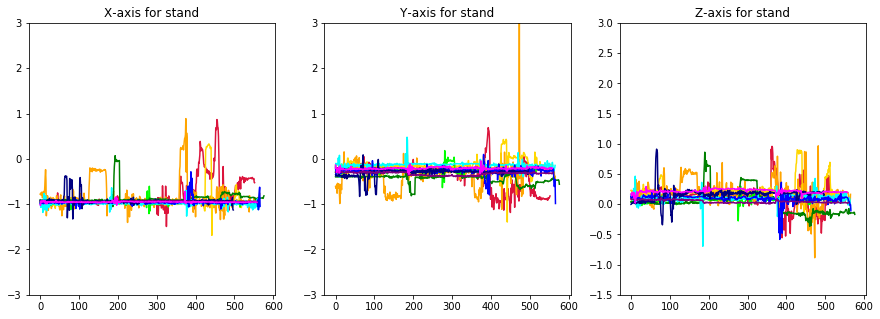

plotting  stairs


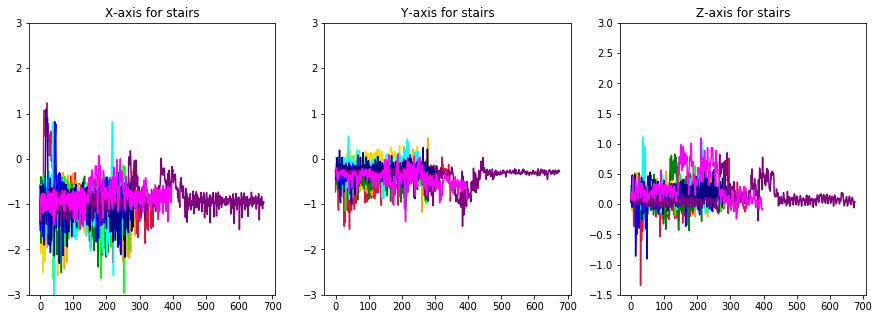

plotting  walk


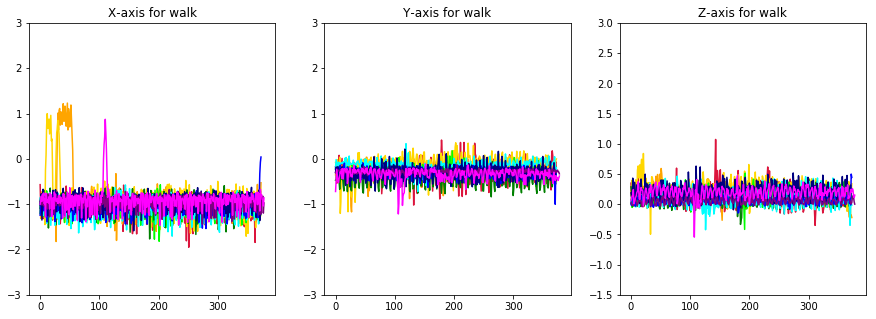

In [42]:
plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [43]:
roll, pitch, yaw = calc_rpy(X_all, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

print(rpy.shape)

(19931, 3)


# Apply PCA and LDA

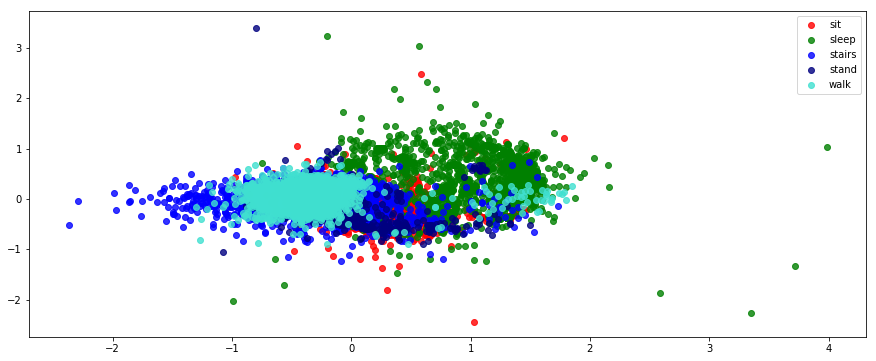

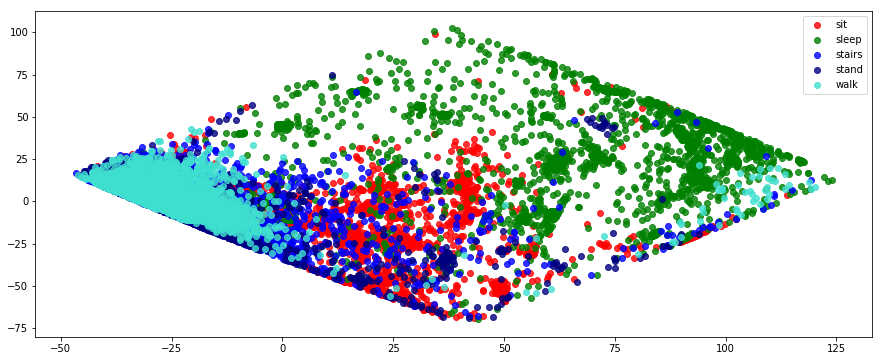

In [44]:
# apply PCA and LDA to X_norm and rpy
X_pca = apply_pca(X_all, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)

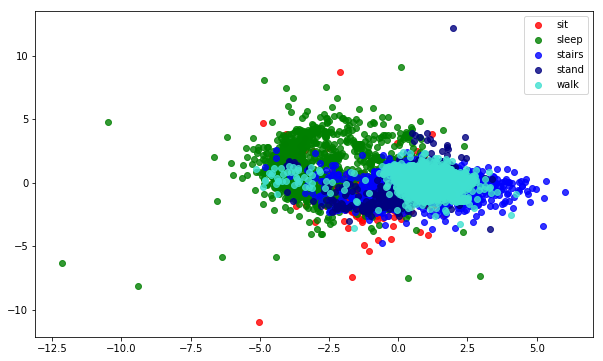

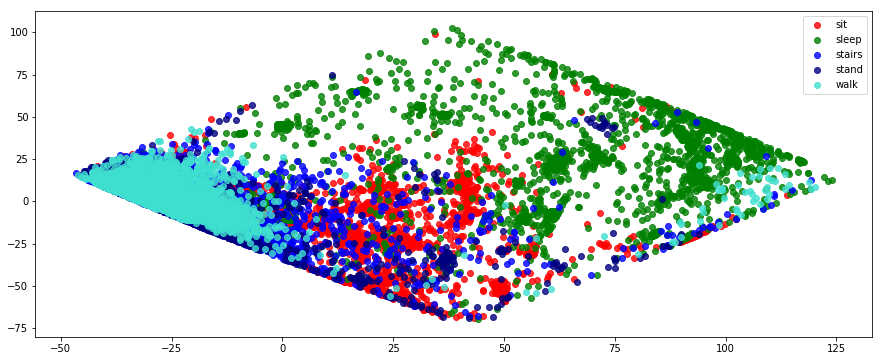

In [45]:
X_lda = apply_lda(X_all, y_all, label_list)
rpy_lda = apply_pca(rpy, y_all, label_list)

# Reshape Data (Pure Label)

In [46]:
def prepare_pure_label(X, y, subj_all, new_label_list):
    X_label, y_label = label_grouping(X, y, subj_all, new_label_list)
    
    X_concat = []
    y_concat = []
    for i in range(len(X_label)):
        for j in range(len(X_label[i])):
            X_ol, y_ol = make_overlapping(np.array(X_label[i][j]), y_label[i][j])

            if(len(X_concat)==0):
                X_concat = X_ol
            else:
                X_concat = np.vstack((X_concat, X_ol))

            if(len(y_concat)==0):
                y_concat = y_ol
            else:
                y_concat = np.hstack((y_concat, y_ol))
    
    X_concat_xyz = concat_xyz(X_concat)
    
    return X_concat_xyz, y_concat    

In [47]:
# get label-separated X and y
X_svm, y_svm = prepare_pure_label(X_lda, y_all, subj_all, new_label_list)
y_svm = y_svm.reshape((y_svm.shape[0],))

In [48]:
print(X_svm.shape, y_svm.shape)

(16981, 180) (16981,)


# Reshape Data (Impure Label)

In [49]:
def prepare_impure_label(X, y):
    X_ol, y_ol = make_overlapping(X, y)
    X_concat_ol = concat_xyz(X_ol)
    
    return X_concat_ol, y_ol

In [50]:
X_impure, y_impure = prepare_impure_label(X_lda, y_all)

In [51]:
print(X_impure.shape, y_impure.shape)

(19872, 180) (19872,)


# Split Train and Test Set

In [52]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

X_tr, X_te, y_tr, y_te = train_test_split(X_impure, y_impure, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(11886, 180)
(5095, 180)


# SVM

In [53]:
svm_model = svm_classifier(X_train, y_train)
print("Finished training")

Finished training


In [54]:
y_pred_svm = svm_model.predict(X_test)

## SVM Evaluation

In [55]:
%run eval_score.ipynb

In [57]:
LABELS = ['sit','sleep','stairs','stand','walk']

0.8967615309126594


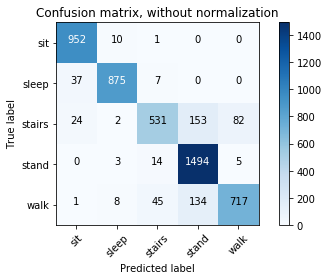

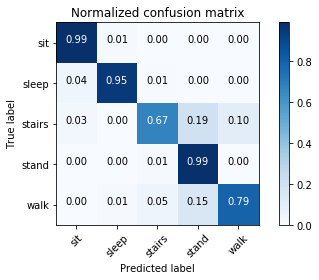

              precision    recall  f1-score   support

         sit       0.94      0.99      0.96       963
       sleep       0.97      0.95      0.96       919
      stairs       0.89      0.67      0.76       792
       stand       0.84      0.99      0.91      1516
        walk       0.89      0.79      0.84       905

   micro avg       0.90      0.90      0.90      5095
   macro avg       0.91      0.88      0.89      5095
weighted avg       0.90      0.90      0.89      5095



In [58]:
acc = accuracy_score(y_test, y_pred_svm)
print(acc)

show_conf_matrix(y_test, y_pred_svm, LABELS)
show_clf_report(y_test, y_pred_svm, LABELS)

# K-NN

In [59]:
nn_model = nn_classifier(X_train, y_train)
print("Finished training")

Finished training


In [60]:
y_pred_nn = nn_model.predict(X_test)

## K-NN Evaluation

0.8153091265947007


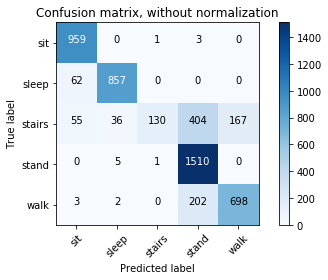

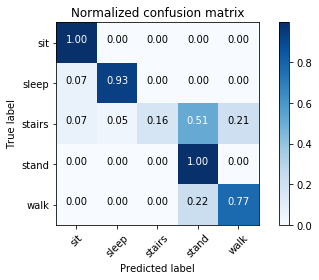

              precision    recall  f1-score   support

         sit       0.89      1.00      0.94       963
       sleep       0.95      0.93      0.94       919
      stairs       0.98      0.16      0.28       792
       stand       0.71      1.00      0.83      1516
        walk       0.81      0.77      0.79       905

   micro avg       0.82      0.82      0.82      5095
   macro avg       0.87      0.77      0.76      5095
weighted avg       0.85      0.82      0.78      5095



In [61]:
acc = accuracy_score(y_test, y_pred_nn)
print(acc)

show_conf_matrix(y_test, y_pred_nn, LABELS)
show_clf_report(y_test, y_pred_nn, LABELS)

# Walk Algorithm

In [66]:
%run classifier_alg.ipynb

In [67]:
# classify walking
walk = calc_walk(X_all)
walk_its = intersection_walk(walk)
walk_pred_p = calc_walk_periods(walk_its)

walk_exact_p = get_exact_walk(y_all)
    
walk_pred = binarize_walk_prd(walk_pred_p, y_all)
walk_exact = binarize_walk_prd(walk_exact_p, y_all)

In [68]:
for w in walk_pred_p:
    print(w.s, w.f)
    
for w in walk_exact_p:
    print(w.s, w.f)

0 240
260 340
1720 2030
2080 2280
3490 3550
3630 4000
4020 4250
5570 5970
5990 6220
6600 6650
7360 7900
9220 9850
10270 10290
11200 11830
12230 12290
13160 13410
13430 13490
13510 13830
15110 15330
15350 15480
15500 15580
15640 15690
15750 15800
15820 15880
15900 16030
16060 16090
17470 17590
17610 17760
17780 17800
17820 17890
17910 18130
18180 18240
19590 19920
0 347
1661 2321
3634 4256
5575 6223
7307 7896
9221 9861
11205 11834
13168 13847
15112 16160
17468 18244


## Walk Algorithm Evaluation

In [69]:
walk_lbl = ['NaN','walk']

0.9336209924238623


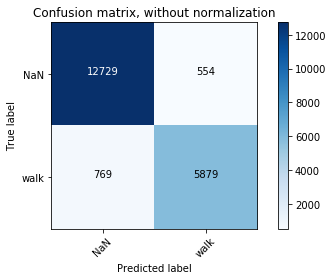

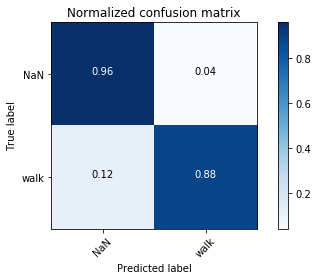

              precision    recall  f1-score   support

         NaN       0.94      0.96      0.95     13283
        walk       0.91      0.88      0.90      6648

   micro avg       0.93      0.93      0.93     19931
   macro avg       0.93      0.92      0.92     19931
weighted avg       0.93      0.93      0.93     19931



In [70]:
acc = accuracy_score(walk_exact, walk_pred)
print(acc)

show_conf_matrix(walk_exact, walk_pred, walk_lbl)
show_clf_report(walk_exact, walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [71]:
X_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
X_non_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

X_walk = np.array(X_walk)
X_non_walk = np.array(X_non_walk)

y_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
y_non_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

y_walk = np.array(y_walk)
y_non_walk = np.array(y_non_walk)

In [72]:
print(X_walk.shape, X_non_walk.shape)
print(y_walk.shape, y_non_walk.shape)

(6433, 3) (13498, 3)
(6433,) (13498,)


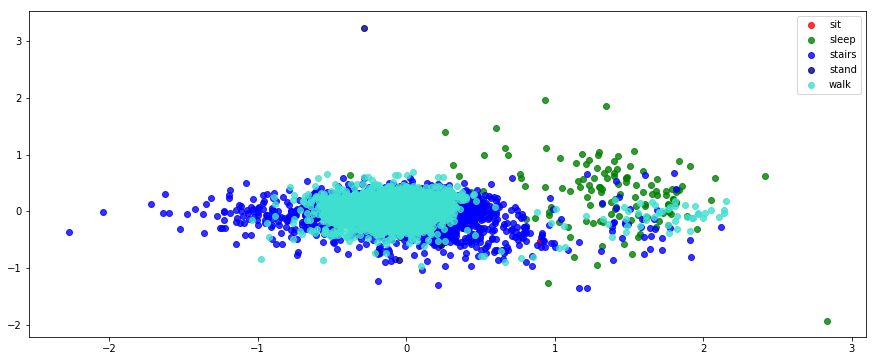

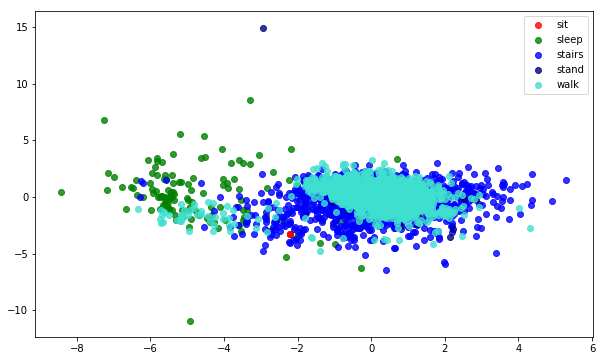

In [73]:
Xw_pca = apply_pca(X_walk, y_walk, label_list)
Xw_lda = apply_lda(X_walk, y_walk, label_list)

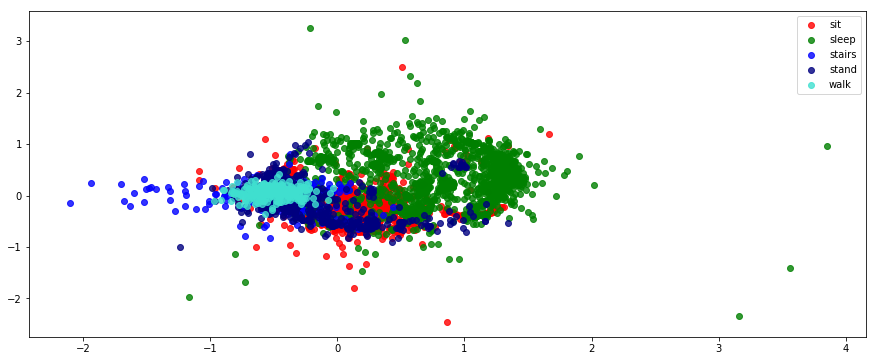

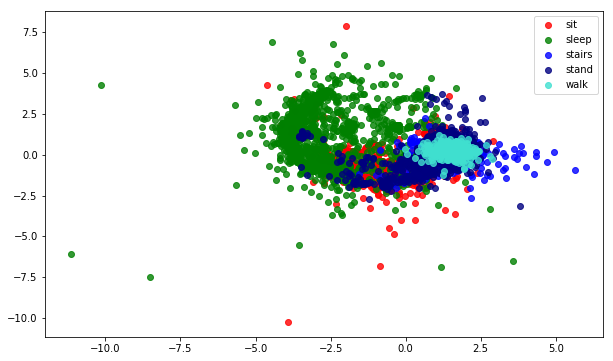

In [74]:
Xnw_pca = apply_pca(X_non_walk, y_non_walk, label_list)
Xnw_lda = apply_lda(X_non_walk, y_non_walk, label_list)

In [75]:
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw_lda, y_walk, test_size=0.3, random_state=42)

Xnw_train, Xnw_test, ynw_train, ynw_test = train_test_split(Xnw_lda, y_non_walk, test_size=0.3, random_state=42)

In [76]:
svm_walk = svm_classifier(Xw_train, yw_train)
print("Finish Training")

Finish Training


In [77]:
svm_non_walk = svm_classifier(Xnw_train, ynw_train)
print("Finish Training")

Finish Training


In [78]:
yw_pred = svm_walk.predict(Xw_test)
ynw_pred = svm_non_walk.predict(Xnw_test)

0.655958549222798


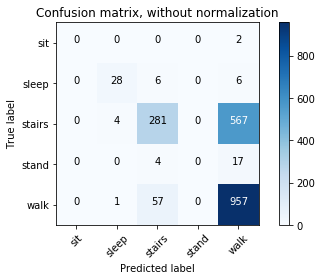

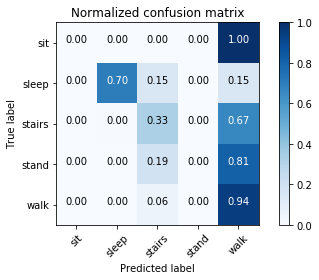

              precision    recall  f1-score   support

         sit       0.00      0.00      0.00         2
       sleep       0.85      0.70      0.77        40
      stairs       0.81      0.33      0.47       852
       stand       0.00      0.00      0.00        21
        walk       0.62      0.94      0.75      1015

   micro avg       0.66      0.66      0.66      1930
   macro avg       0.45      0.39      0.40      1930
weighted avg       0.70      0.66      0.62      1930



/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
acc = accuracy_score(yw_test, yw_pred)
print(acc)

show_conf_matrix(yw_test, yw_pred, LABELS)
show_clf_report(yw_test, yw_pred, LABELS)

0.8725925925925926


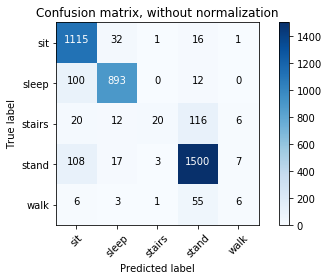

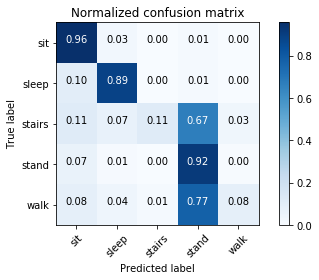

              precision    recall  f1-score   support

         sit       0.83      0.96      0.89      1165
       sleep       0.93      0.89      0.91      1005
      stairs       0.80      0.11      0.20       174
       stand       0.88      0.92      0.90      1635
        walk       0.30      0.08      0.13        71

   micro avg       0.87      0.87      0.87      4050
   macro avg       0.75      0.59      0.61      4050
weighted avg       0.87      0.87      0.86      4050



In [80]:
acc = accuracy_score(ynw_test, ynw_pred)
print(acc)

show_conf_matrix(ynw_test, ynw_pred, LABELS)
show_clf_report(ynw_test, ynw_pred, LABELS)

# Combine SVM and Walk Algorithm (v2)

In [290]:
print(y_pred_svm)

[1 5 3 ... 1 1 2]


# Note

Window Length : Accuracy

40 : 0.9016

30 : 0.9271

5 : 0.9898